# YOLOX-S-640 Detector - Inference

- Run trained YOLOX-S-640 model.
- Generate image crops with bounding boxes detected (additional margin=16). Both train and test.
- Drop more noisy images/bbx.

In [1]:
import sys
sys.path.append("../code/src_object_detector/YOLOX")
sys.path.append("../code/src")
import cdc
from cdc.common.utils import *
from cdc.common.constants import *
from cdc.yolo.tools import *
from cdc.yolo.inference import *
from cdc.utils.imaging import *

/home/mpware/miniconda3/envs/ml310/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import numpy as np
import pandas as pd
import glob
import json
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=0.8)

import time, os, random, shutil
from tqdm.auto import tqdm
import torch
import cv2

from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit, KFold, GroupKFold, StratifiedGroupKFold

from globox.boundingbox import BoundingBox, BoxFormat
from globox.annotation import Annotation
from globox.annotationset import AnnotationSet

In [19]:
VERSION = "v3.2.0"
DATA_ROOT = "../data"
DATA_HOME = "../yolo_models/"
CONVERT_HOME = DATA_HOME + "data_coco_%s/"%VERSION
LABELS_HOME = os.path.join(DATA_HOME, "data_%s/labels/"%VERSION)
TRAIN_HOME = os.path.join(DATA_HOME, "data_%s/images/"%VERSION)
MODEL_YOLOX_HOME = "../code/src_object_detector/YOLOX/YOLOX_outputs"
TEST_FILE = os.path.join(DATA_ROOT, "test.csv")
TEST_HOME = os.path.join(DATA_ROOT, "images_cytologia")

ROOT =  "yolox_s"
IMG_SIZE = 640
DEVICE = "gpu"
TEST_CONFIDENCE = 0.001
PADDING_POLICY = "full"
NMS_THRESHOLD = 0.30
WBF_IOU = 0.25

SEEDS = [42]
FOLDS = 4
SURFACE_BINS = 3
SURFACE_RATIO_BINS = 4

# Dump BBX for classifiers
CROP_MARGINS = 16
CROP_FILE = os.path.join(DATA_ROOT, "boxes", "%s_%d_%s_%.4f_%.3f_%.3f_%s_m%d_seed42.parquet"%(ROOT, IMG_SIZE, VERSION, TEST_CONFIDENCE, NMS_THRESHOLD, WBF_IOU, PADDING_POLICY, CROP_MARGINS))
CROP_FILE_TRAIN_CLEANED = os.path.join(DATA_ROOT, "boxes", "%s_%d_%s_%.4f_%.3f_%.3f_%s_m%d_seed42_train_cleaned.parquet"%(ROOT, IMG_SIZE, VERSION, TEST_CONFIDENCE, NMS_THRESHOLD, WBF_IOU, PADDING_POLICY, CROP_MARGINS))
CROP_FILE_TEST_CLEANED = os.path.join(DATA_ROOT, "boxes", "%s_%d_%s_%.4f_%.3f_%.3f_%s_m%d_seed42_test_cleaned.parquet"%(ROOT, IMG_SIZE, VERSION, TEST_CONFIDENCE, NMS_THRESHOLD, WBF_IOU, PADDING_POLICY, CROP_MARGINS))
CROP_HOME_TRAIN = os.path.join(DATA_ROOT, "boxes", "%s_%d_%s_%.4f_%.3f_%.3f_%s_m%d_seed42_train_cleaned"%(ROOT, IMG_SIZE, VERSION, TEST_CONFIDENCE, NMS_THRESHOLD, WBF_IOU, PADDING_POLICY, CROP_MARGINS))
CROP_HOME_TEST = os.path.join(DATA_ROOT, "boxes", "%s_%d_%s_%.4f_%.3f_%.3f_%s_m%d_seed42_test_cleaned"%(ROOT, IMG_SIZE, VERSION, TEST_CONFIDENCE, NMS_THRESHOLD, WBF_IOU, PADDING_POLICY, CROP_MARGINS))
os.makedirs(CROP_HOME_TRAIN, exist_ok=True)
os.makedirs(CROP_HOME_TEST, exist_ok=True)

NOISY = [
    "5d2a7d73-9.jpg", # 4 LLC, only 1 fine, other are RBC?
    "d36dccc2-a.jpg", # 5 LLC, only 1 fine, other are RBC?
    "33de695e-7.jpg", # 6 LLC, only 2 fine, other are RBC?
    "a1f27f10-1.jpg", # 3 LLC, only 2 fine, other are RBC?
    "6590e79b-5.jpg", # 2 B, only 1 fine, other are RBC?
    "9b376928-a.jpg", # 2 LLC, only 1 fine, other are RBC?
    "281a67c7-2.jpg", # 3 LLC, only 1 fine, other are RBC?
    "7956365c-b.jpg", # 2 LLC, only 1 fine, other are RBC?
    "10cacd74-c.jpg", # 2 LLC, only 1 fine, other are RBC?
    "1a93b747-8.jpg", # LLC again,
    "050c49f1-e.jpg", # LLC again,
    "05c9cdff-b.jpg", # LLC again,
    "d2ae8e9a-5.jpg", # LLC again,
    "40d73820-f.jpg", # LLC again,
    "130d22a5-c.jpg", # LLC again,
    "6db17eb3-6.jpg", # LLC again,
    "440fea0c-1.jpg", # LLC again,
    "5d938639-2.jpg", # LLC again,
    "a256acef-1.jpg", # Bad class (B)
    "1ca98bb7-b.jpg", # Really too large
    "103c3665-4.jpg", # Really too large
    "3cbfb11f-1.jpg", # Too confusing
    "3d18e248-5.jpg", # Some RBC
    "58b554ed-c.jpg", # Some partial RBC
    "15801706-9.jpg", # Spurious MO
    "95d6d905-b.jpg", # Spurious LLC
    "c517ba8f-a.jpg", # Spurious LLC
    "d96fb6b7-7.jpg", # Spurious
    # More noisy images removed
    "c47f2eb4-a.jpg", # Spurious LLC
    "15801706-9.jpg", # Spurious MO
    "9f483bf6-a.jpg", # Spurious LLC
    "b1b42c5a-4.jpg", # Spurious EO
    "3d18e248-5.jpg", # Spurious MBL
    "10cacd74-c.jpg", # Spurious LLC
    "0e940897-f.jpg", # Spurious B
    "11debb3c-a.jpg", # Small
    "11ff62d3-3.jpg", # Small
    "0a17df41-b.jpg", # Small
    "281a67c7-2.jpg", # Small
    "4824bb6c-7.jpg", # Small
    "e0fef149-3.jpg", # Small
    "26125a38-e.jpg", # Small
    "e548c2b8-3.jpg", # Small
    "1a93b747-8.jpg", # Small
    "9f483bf6-a.jpg", # Small
    "139ed36e-6.jpg", # Small
    "130d22a5-c.jpg", # Small
    "cb0cc9d8-8.jpg", # Small
    "5d938639-2.jpg", # Small
    "40df37f6-7.jpg", # Small
    "0e940897-f.jpg", # Small
    "ef002fe8-b.jpg", # Small
    "8a48042d-c.jpg", # Small
    "e0913a58-6.jpg", # Small
    "03e7b693-1.jpg", # Small
    "46fa539b-4.jpg", # Small
    "1d171f75-8.jpg", # Small
    "b9b3e673-7.jpg", # Small
    "f82048bc-4-jpg", # Small
]
seed_everything_now(SEEDS[0])

In [4]:
cv_pd = pd.read_parquet(os.path.join(DATA_ROOT, "cv4_seed42_multilabel.parquet")) # BB from train dataset
cv_pd_ = cv_pd[["NAME", "img_width", "img_height", "fold_s42", "bbx"]].explode('bbx').reset_index(drop=True)
print(cv_pd_.shape)
cv_pd_["trustii_id"] = cv_pd_.index
cv_pd_["x1"] = cv_pd_["bbx"].apply(lambda x: x[0]).astype(np.int32)
cv_pd_["y1"] = cv_pd_["bbx"].apply(lambda x: x[2]).astype(np.int32)
cv_pd_["x2"] = cv_pd_["bbx"].apply(lambda x: x[1]).astype(np.int32)
cv_pd_["y2"] = cv_pd_["bbx"].apply(lambda x: x[3]).astype(np.int32)
cv_pd_["class"] = cv_pd_["bbx"].apply(lambda x: x[4]).astype(np.int32)
cv_pd_["class"] = cv_pd_["class"].map(class_mapping)
cv_pd_ = cv_pd_[["trustii_id", "NAME", "x1", "y1", "x2", "y2", "class", "img_width", "img_height", "fold_s42"]]
# display(cv_pd_)
cv_pd = pd.merge(cv_pd, cv_pd_.groupby("NAME")[["trustii_id"]].agg(trustii_ids=("trustii_id", list)).reset_index(), on="NAME", how="left")
cv_pd.shape

(52586, 5)


(48263, 43)

In [5]:
MODELS = {

    "yolox_s_%s_640_seed_42"%VERSION: {
        "fold0":  (MODEL_YOLOX_HOME + "/yolox_s_%s_%d_seed_42_fold0"%(VERSION.replace(".", ""), IMG_SIZE), IMG_SIZE),
        "fold1":  (MODEL_YOLOX_HOME + "/yolox_s_%s_%d_seed_42_fold1"%(VERSION.replace(".", ""), IMG_SIZE), IMG_SIZE),
        "fold2":  (MODEL_YOLOX_HOME + "/yolox_s_%s_%d_seed_42_fold2"%(VERSION.replace(".", "") ,IMG_SIZE), IMG_SIZE),
        "fold3":  (MODEL_YOLOX_HOME + "/yolox_s_%s_%d_seed_42_fold3"%(VERSION.replace(".", ""), IMG_SIZE), IMG_SIZE),
    }    
}

## Infer YOLOX folds and compute OOF

In [ ]:
for name, _ in MODELS.items():
    roi_predictions = []
    for fold in sorted(cv_pd["fold_s42"].unique()):
        valid_pd = cv_pd[cv_pd["fold_s42"] == fold]
        files = [os.path.join(TRAIN_HOME, f.split("/")[-1]) for f in valid_pd["filename"].values]
        path, imgsize = MODELS[name].get("fold%d"%fold) if MODELS[name].get("fold%d"%fold) is not None else (None, None)
        if path is not None:
            print("Path:", path)            
            if "yolox" in path:
                roi_predictions_ = predict_yolox(None, path + "/best_ckpt.pth", test_conf=TEST_CONFIDENCE, nmsthre=NMS_THRESHOLD, image_size=imgsize, files=files, device=DEVICE)
            roi_predictions_["fold_s42"] = fold
            roi_predictions.append(roi_predictions_)
    roi_predictions = pd.concat(roi_predictions, ignore_index=True)

/tmp/ipykernel_357917/220380107.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  roi_predictions_oof_pd[["bbx_xtl", "bbx_ytl", "bbx_xbr", "bbx_ybr"]] = roi_predictions_oof_pd[["bbx_xtl", "bbx_ytl", "bbx_xbr", "bbx_ybr", "slide_width", "slide_height"]].apply(lambda x: fix_bbox(x[0], x[1], x[2], x[3], x[4], x[5]), axis=1, result_type="expand")
/tmp/ipykernel_357917/220380107.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  roi_predictions_oof_pd["bb"] = roi_predictions_oof_pd[["bbx_xtl", "bbx_xbr", "bbx_ytl", "bbx_ybr", "class", "roi_surface_ratio", "score"]].apply(lambda x: (x[0], x[1], x[2], x[3], x[4], x[5],

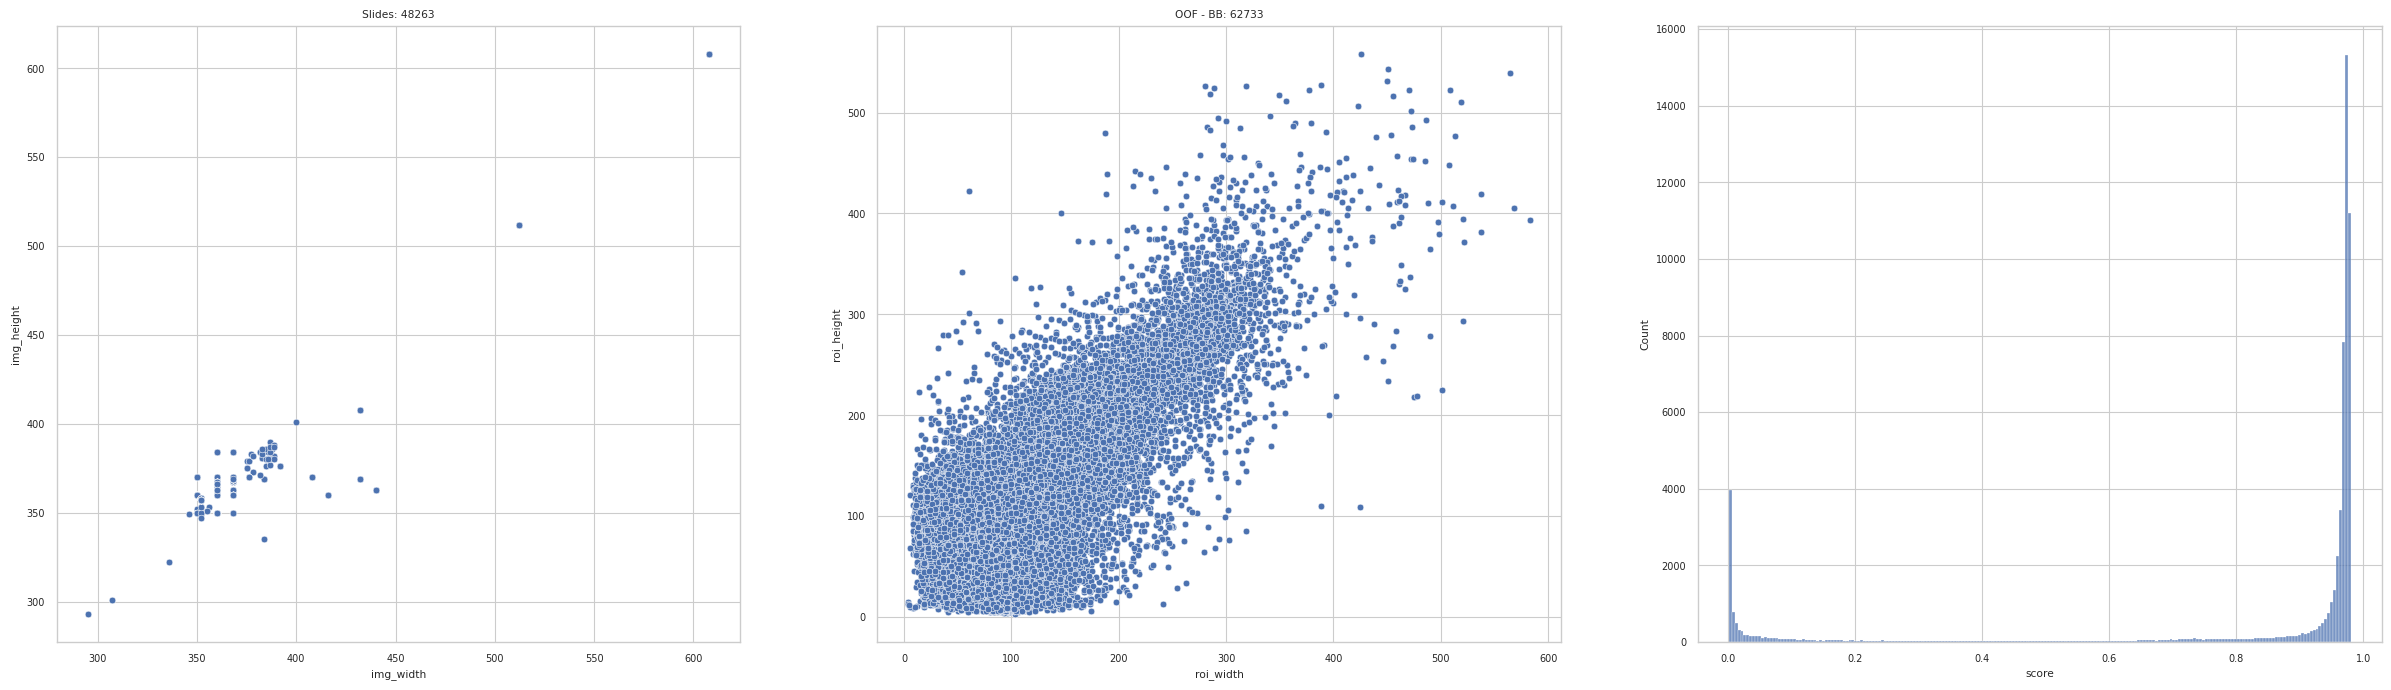

In [8]:
roi_predictions_oof_pd = roi_predictions.copy()
roi_predictions_oof_pd["bbx_xtl"] = roi_predictions_oof_pd["bbx_xtl"].apply(lambda x: np.round(x)).astype(np.int32)
roi_predictions_oof_pd["bbx_xbr"] = roi_predictions_oof_pd["bbx_xbr"].apply(lambda x: np.round(x)).astype(np.int32)
roi_predictions_oof_pd["bbx_ybr"] = roi_predictions_oof_pd["bbx_ybr"].apply(lambda x: np.round(x)).astype(np.int32)
roi_predictions_oof_pd["bbx_ytl"] = roi_predictions_oof_pd["bbx_ytl"].apply(lambda x: np.round(x)).astype(np.int32)
roi_predictions_oof_pd["roi_width"] = roi_predictions_oof_pd["bbx_xbr"] - roi_predictions_oof_pd["bbx_xtl"]
roi_predictions_oof_pd["roi_height"] = roi_predictions_oof_pd["bbx_ybr"] - roi_predictions_oof_pd["bbx_ytl"]
roi_predictions_oof_pd["roi_surface"] = roi_predictions_oof_pd["roi_width"]*roi_predictions_oof_pd["roi_height"]
roi_predictions_oof_pd["roi_surface_ratio"] = roi_predictions_oof_pd["roi_surface"]*100./(roi_predictions_oof_pd["slide_width"]*roi_predictions_oof_pd["slide_height"])
roi_predictions_oof_pd[["bbx_xtl", "bbx_ytl", "bbx_xbr", "bbx_ybr"]] = roi_predictions_oof_pd[["bbx_xtl", "bbx_ytl", "bbx_xbr", "bbx_ybr", "slide_width", "slide_height"]].apply(lambda x: fix_bbox(x[0], x[1], x[2], x[3], x[4], x[5]), axis=1, result_type="expand")
roi_predictions_oof_pd = roi_predictions_oof_pd.rename(columns={'filename': 'NAME', 'slide_width': 'img_width', 'slide_height': 'img_height'})
roi_predictions_oof_pd["bb"] = roi_predictions_oof_pd[["bbx_xtl", "bbx_xbr", "bbx_ytl", "bbx_ybr", "class", "roi_surface_ratio", "score"]].apply(lambda x: (x[0], x[1], x[2], x[3], x[4], x[5], x[6]), axis=1)
fig, ax = plt.subplots(1, 3, figsize=(30,8))
d = sns.scatterplot(data=roi_predictions_oof_pd, x="img_width", y="img_height", ax=ax[0])
d = sns.scatterplot(data=roi_predictions_oof_pd, x="roi_width", y="roi_height", ax=ax[1])
d = sns.histplot(data=roi_predictions_oof_pd, x="score", ax=ax[2])
d = ax[0].set_title("Slides: %d" % roi_predictions_oof_pd["NAME"].nunique())
d = ax[1].set_title("OOF - BB: %d" % roi_predictions_oof_pd.shape[0])
plt.show()

In [9]:
oof_pd = roi_predictions_oof_pd.groupby(["NAME", "img_width", "img_height", "fold_s42"]).agg(oof_bbx=("bb", list), bb_score_avg=("score", np.mean), oof_roi_width_max=("roi_width", np.max), oof_roi_height_max=("roi_height", np.max)).reset_index()
oof_pd["oof_bbs"] = oof_pd["oof_bbx"].apply(lambda x: len(x))
oof_pd = pd.merge(oof_pd, cv_pd, on=["NAME", "img_width", "img_height", "fold_s42"], how="inner")
print("Too much predictions:", oof_pd[oof_pd["oof_bbs"] > oof_pd["bbs"]].shape)
print("Not enough predictions:", oof_pd[oof_pd["oof_bbs"] < oof_pd["bbs"]].shape)
print("Equal predictions:", oof_pd[oof_pd["oof_bbs"] == oof_pd["bbs"]].shape)
not_enough_oof = oof_pd[oof_pd["oof_bbs"] < oof_pd["bbs"]]["NAME"].unique()
# Padding
oof_pd["oof_bbx"] = oof_pd[["oof_bbx", "bbs", "img_width", "img_height"]].apply(lambda x: fit_format(x[0], x[1], x[2], x[3], padding=True, padding_policy=PADDING_POLICY), axis=1)
oof_pd["oof_bbs"] = oof_pd["oof_bbx"].apply(lambda x: len(x))
oof_pd["bbs"] = oof_pd["bbx"].apply(lambda x: len(x))
oof_pd["bb_score_avg"] = oof_pd["oof_bbx"].apply(lambda x: compute_bbx_avg_score(x))
print("After padding")
print("Too much predictions:", oof_pd[oof_pd["oof_bbs"] > oof_pd["bbs"]].shape)
print("Not enough predictions:", oof_pd[oof_pd["oof_bbs"] < oof_pd["bbs"]].shape)
print("Equal predictions:", oof_pd[oof_pd["oof_bbs"] == oof_pd["bbs"]].shape)

/tmp/ipykernel_357917/2197562094.py:1: FutureWarning: The provided callable <function mean at 0x7f6f7c5b3010> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  oof_pd = roi_predictions_oof_pd.groupby(["NAME", "img_width", "img_height", "fold_s42"]).agg(oof_bbx=("bb", list), bb_score_avg=("score", np.mean), oof_roi_width_max=("roi_width", np.max), oof_roi_height_max=("roi_height", np.max)).reset_index()
/tmp/ipykernel_357917/2197562094.py:1: FutureWarning: The provided callable <function max at 0x7f6f7c5b2710> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  oof_pd = roi_predictions_oof_pd.groupby(["NAME", "img_width", "img_height", "fold_s42"]).agg(oof_bbx=("bb", list), bb_score_avg=("score", np.mean), oof_roi_width_max=("roi_width", np.max), 

Too much predictions: (7293, 48)
Not enough predictions: (20, 48)
Equal predictions: (40950, 48)
After padding
Too much predictions: (0, 48)
Not enough predictions: (0, 48)
Equal predictions: (48263, 48)


In [10]:
oof_pd.to_parquet(os.path.join(DATA_ROOT, "cv4_seed42_multilabel_oof_%s_%d_%s.parquet" % (ROOT, IMG_SIZE, VERSION)))

## Compute OOF + Create a clean Ground Truth <=> OOF mapping (highest GIOU with BBX train dataset)

In [12]:
# To submission format
submission_pd = oof_pd[["NAME", "bb_score_avg", "oof_bbx", "trustii_ids"]].explode(['oof_bbx', 'trustii_ids']).rename(columns={'trustii_ids':'trustii_id'})
submission_pd["x1"] = submission_pd["oof_bbx"].apply(lambda x: x[0]).astype(np.int32)
submission_pd["y1"] = submission_pd["oof_bbx"].apply(lambda x: x[2]).astype(np.int32)
submission_pd["x2"] = submission_pd["oof_bbx"].apply(lambda x: x[1]).astype(np.int32)
submission_pd["y2"] = submission_pd["oof_bbx"].apply(lambda x: x[3]).astype(np.int32)
submission_pd["class"] = submission_pd["oof_bbx"].apply(lambda x: x[4]).astype(np.int32)
submission_pd["score"] = submission_pd["oof_bbx"].apply(lambda x: x[-1])
submission_csv_pd = submission_pd[["trustii_id", "NAME", "x1", "y1", "x2", "y2", "score", "bb_score_avg", "class"]].copy()
submission_csv_pd["class"] = "PNN"

In [13]:
score, bbx_mapping = compute_metric(cv_pd_[cv_pd_["NAME"].isin(submission_csv_pd["NAME"].unique())], submission_csv_pd, giou_only=False)
score

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48263/48263 [11:37<00:00, 69.22it/s]


0.20255215686383418

In [6]:
bbx_mapping.to_parquet(CROP_FILE)
bbx_mapping

trustii_id            NAME   x1   y1   x2   y2 class_x  img_width  \
0            0  00008cef-c.jpg  110  114  262  262     PNN        368   
0            1  00010aae-3.jpg   95   82  252  275      EO        352   
0            2  00016779-d.jpg   91  107  256  247      EO        352   
0            3  0003ab57-1.jpg  113  110  259  261     PNN        368   
0            4  000a7dc3-d.jpg  134  130  235  232     LyB        368   
..         ...             ...  ...  ...  ...  ...     ...        ...   
0        52581  fff4e97c-a.jpg  115  124  254  244       B        368   
0        52582  fff5d8b3-3.jpg   63  309  205  366     PNN        360   
1        52583  fff5d8b3-3.jpg   93   71  272  303     MoB        360   
0        52584  fffb3880-0.jpg  100   93  261  270      PM        360   
0        52585  fffb64d1-5.jpg  123  116  240  244       B        360   

    img_height  fold_s42  boundingbox_id      giou class_y  pred_x1  pred_y1  \
0          370         1               0  0.967315     PNN      109      112   
0          357         0               0  0.966874     PNN       96       85   
0          357         0               0  0.947033     PNN       91      111   
0          369         0               0  0.980041     PNN      113      111   
0          369         2               0  1.000000     PNN      134      130   
..         ...       ...             ...       ...     ...      ...      ...   
0          369         3               0  1.000000     PNN      115      124   
0          367         2               1  0.923133     PNN       64      306   
1          367         2               0  0.963254     PNN       94       74   
0          360         1               0  0.982660     PNN      100       92   
0          360         0               0  0.991525     PNN      123      116   

    pred_x2  pred_y2  pred_score  rescaled_iou  
0       260      262    0.973193      0.983657  
0       253      274    0.968320      0.983437  
0       259      246    0.968794      0.973516  
0       260      260    0.976097      0.990020  
0       235      232    0.974633      1.000000  
..      ...      ...         ...           ...  
0       254      244    0.966371      1.000000  
0       202      366    0.170519      0.961567  
1       271      300    0.965365      0.981627  
0       262      269    0.975598      0.991330  
0       241      244    0.975142      0.995763  

[52586 rows x 19 columns]

Noisy images removed: (52449, 22)
Padded boxes removed: (52441, 22)
Negative GIOU boxes removed: (52211, 22)
Duplicated boxes matching removed: (52197, 22)


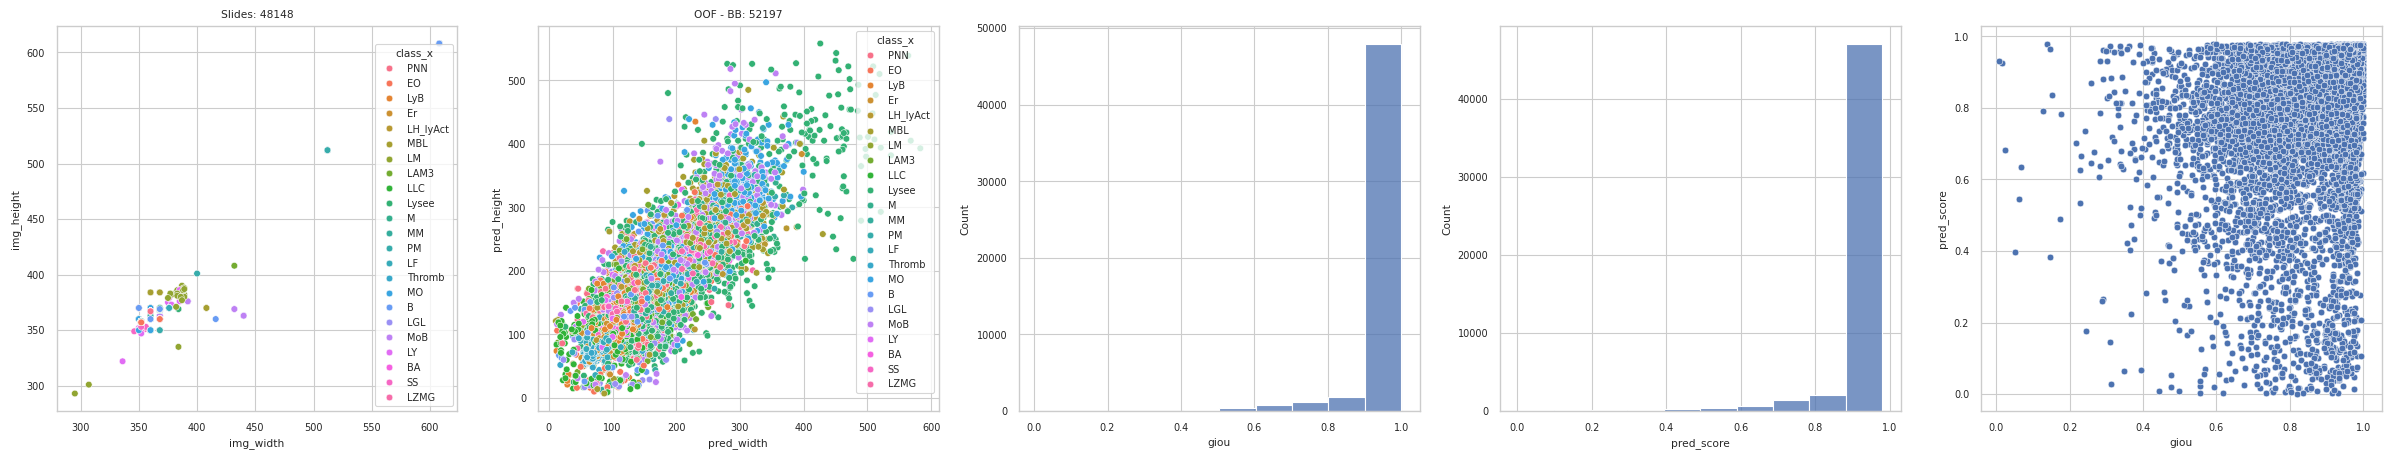

In [7]:
# Cleaning training dataset
train_pd = bbx_mapping.copy()
train_pd["class"] = train_pd["class_x"].map(class_mapping_inv)
train_pd["pred_width"] = train_pd["pred_x2"] - train_pd["pred_x1"]
train_pd["pred_height"] = train_pd["pred_y2"] - train_pd["pred_y1"]
if NOISY is not None:
    train_pd = train_pd[~train_pd["NAME"].isin(NOISY)]
    print("Noisy images removed:", train_pd.shape)
train_pd = train_pd[train_pd["pred_score"] > 0]
print("Padded boxes removed:", train_pd.shape)
train_pd = train_pd[train_pd["giou"] > 0]
print("Negative GIOU boxes removed:", train_pd.shape)    
# Remove predicted boxes with more than one GT matching (keep highest GIOU)
train_pd = train_pd.sort_values(["NAME", "boundingbox_id", "giou"], ascending=[True, True, False]).reset_index(drop=True)
more_than_one_mapping_pd = train_pd.groupby(["NAME", "boundingbox_id"])[["trustii_id", "giou"]].agg(trustii_id=("trustii_id", 'count'), trustii_ids=("trustii_id", list), gious=("giou", list)).reset_index().sort_values(["trustii_id"], ascending=[False]).reset_index(drop=True)
# remove_more_than_one_mapping_pd = more_than_one_mapping_pd[more_than_one_mapping_pd["trustii_id"]>1]
more_than_one_mapping_pd["trustii_id_selected"] = more_than_one_mapping_pd["trustii_ids"].apply(lambda x: x[0])
train_pd = train_pd[train_pd["trustii_id"].isin(more_than_one_mapping_pd["trustii_id_selected"].unique())]
print("Duplicated boxes matching removed:", train_pd.shape)
fig, ax = plt.subplots(1, 5, figsize=(30,5))
d = sns.scatterplot(data=train_pd, x="img_width", y="img_height", hue="class_x", ax=ax[0])
d = sns.scatterplot(data=train_pd, x="pred_width", y="pred_height", hue="class_x", ax=ax[1])
d = sns.histplot(data=train_pd, x="giou", ax=ax[2], bins=10)
d = sns.histplot(data=train_pd, x="pred_score", ax=ax[3], bins=10)
d = sns.scatterplot(data=train_pd, x="giou", y="pred_score", ax=ax[4])
d = ax[0].set_title("Slides: %d" % train_pd["NAME"].nunique())
d = ax[1].set_title("OOF - BB: %d" % train_pd.shape[0])
plt.show()   

In [8]:
dump_boxes(train_pd, TRAIN_HOME, CROP_HOME_TRAIN, margins=CROP_MARGINS)
train_pd.to_parquet(CROP_FILE_TRAIN_CLEANED)
train_pd

100%|█████████████████████████████████████████████████████████████████████| 52197/52197 [21:59<00:00, 39.55it/s]


trustii_id            NAME   x1   y1   x2   y2 class_x  img_width  \
0               0  00008cef-c.jpg  110  114  262  262     PNN        368   
1               1  00010aae-3.jpg   95   82  252  275      EO        352   
2               2  00016779-d.jpg   91  107  256  247      EO        352   
3               3  0003ab57-1.jpg  113  110  259  261     PNN        368   
4               4  000a7dc3-d.jpg  134  130  235  232     LyB        368   
...           ...             ...  ...  ...  ...  ...     ...        ...   
52206       52581  fff4e97c-a.jpg  115  124  254  244       B        368   
52207       52583  fff5d8b3-3.jpg   93   71  272  303     MoB        360   
52208       52582  fff5d8b3-3.jpg   63  309  205  366     PNN        360   
52209       52584  fffb3880-0.jpg  100   93  261  270      PM        360   
52210       52585  fffb64d1-5.jpg  123  116  240  244       B        360   

       img_height  fold_s42  ...  pred_x1  pred_y1 pred_x2  pred_y2  \
0             370         1  ...      109      112     260      262   
1             357         0  ...       96       85     253      274   
2             357         0  ...       91      111     259      246   
3             369         0  ...      113      111     260      260   
4             369         2  ...      134      130     235      232   
...           ...       ...  ...      ...      ...     ...      ...   
52206         369         3  ...      115      124     254      244   
52207         367         2  ...       94       74     271      300   
52208         367         2  ...       64      306     202      366   
52209         360         1  ...      100       92     262      269   
52210         360         0  ...      123      116     241      244   

       pred_score  rescaled_iou  class  pred_width  pred_height  \
0        0.973193      0.983657      0         151          150   
1        0.968320      0.983437      3         157          189   
2        0.968794      0.973516      3         168          135   
3        0.976097      0.990020      0         147          149   
4        0.974633      1.000000     10         101          102   
...           ...           ...    ...         ...          ...   
52206    0.966371      1.000000     14         139          120   
52207    0.965365      0.981627     18         177          226   
52208    0.170519      0.961567      0         138           60   
52209    0.975598      0.991330      6         162          177   
52210    0.975142      0.995763     14         118          128   

                       filename  
0          00008cef-c-0-PNN.png  
1           00010aae-3-1-EO.png  
2           00016779-d-2-EO.png  
3          0003ab57-1-3-PNN.png  
4          000a7dc3-d-4-LyB.png  
...                         ...  
52206    fff4e97c-a-52581-B.png  
52207  fff5d8b3-3-52583-MoB.png  
52208  fff5d8b3-3-52582-PNN.png  
52209   fffb3880-0-52584-PM.png  
52210    fffb64d1-5-52585-B.png  

[52197 rows x 23 columns]

## Plot some predictions in validation

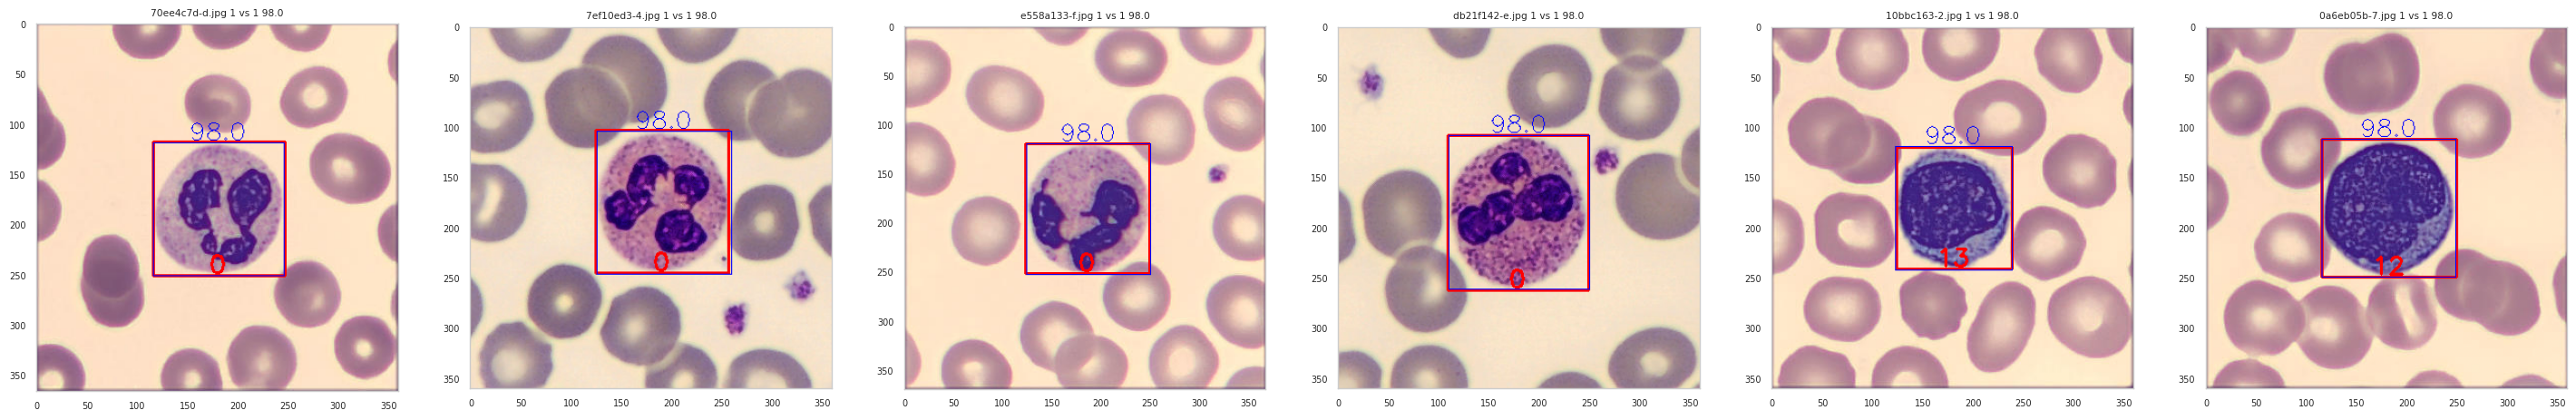

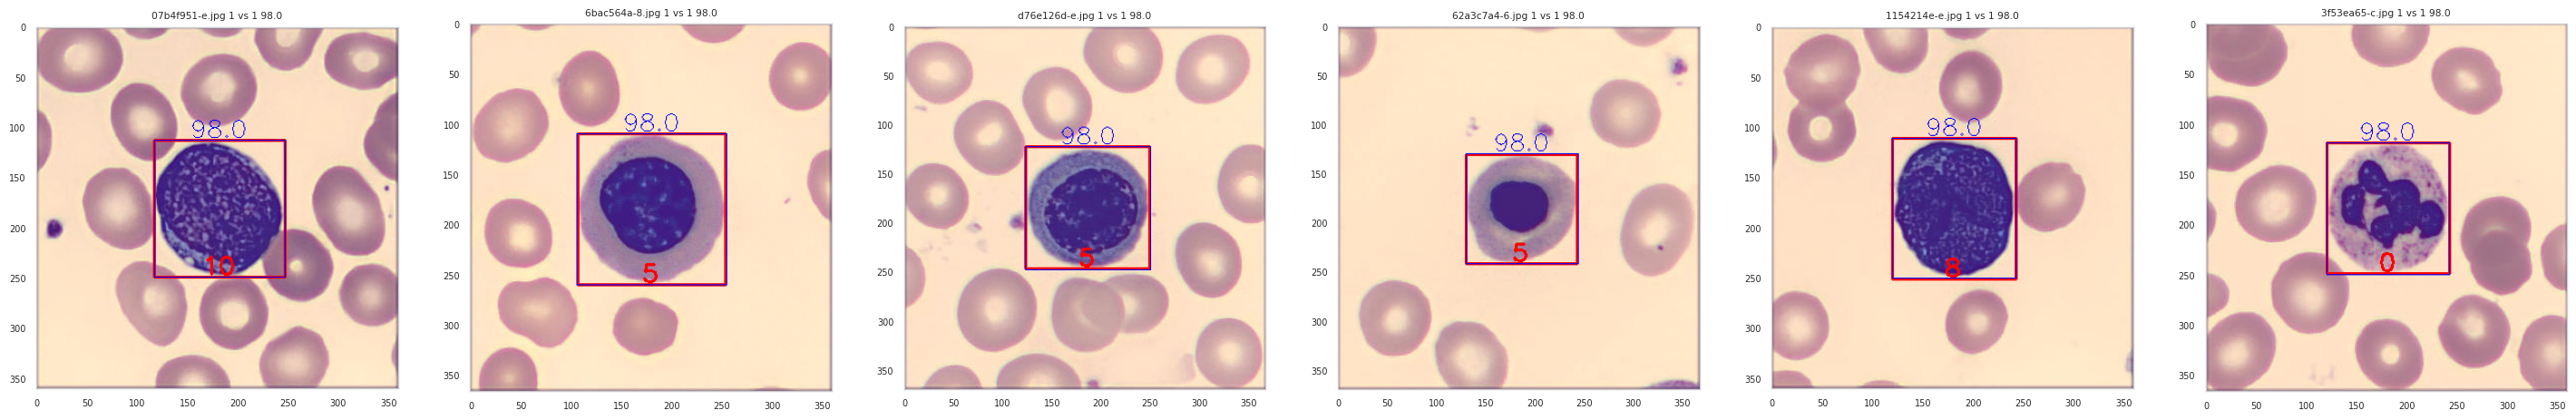

In [18]:
df = oof_pd.sort_values(["bb_score_avg"], ascending=[False])
i, j = 0, 0
for idx, row in df.iterrows():
    j = j + 1
    if j > 6*2:
        break    
    filename = row["NAME"]
    gt_bbx = row["bbx"]
    gt_bbs = row["bbs"]    
    oof_bbx = row["oof_bbx"]
    oof_bbs = row["oof_bbs"]
    oof_score_avg = row["bb_score_avg"]
    img = np.array(Image.open(os.path.join(TRAIN_HOME, filename)))

    # GT
    for x1, x2, y1, y2, label in gt_bbx:
        start_point = (int(x1), int(y1))
        end_point = (int(x2), int(y2))
        cv2.rectangle(img, start_point, end_point, color=(255,0,0), thickness=2)
        txt = str("%s" % (label))
        fnt = cv2.FONT_HERSHEY_SIMPLEX
        fnt_scale = 0.8
        fnt_thickness = 2
        textsize = cv2.getTextSize(txt, fnt, fnt_scale, fnt_thickness)[0]
        xc = (x1+x2-textsize[0])/2.
        yc = (y2 - 3)
        cv2.putText(
            img,
            txt,
            (int(xc), int(yc)),
            fontFace=fnt,
            fontScale=fnt_scale,
            color=(255,0, 0),
            thickness=fnt_thickness) 
        
    # OOF
    for x1, x2, y1, y2, klass, surface, score in oof_bbx:
        start_point = (int(x1), int(y1))
        end_point = (int(x2), int(y2))
        cv2.rectangle(img, start_point, end_point, color=(0,0,255), thickness=1)
        txt = str("%.1f" % (score*100))
        fnt = cv2.FONT_HERSHEY_SIMPLEX
        fnt_scale = 0.8
        fnt_thickness = 1
        textsize = cv2.getTextSize(txt, fnt, fnt_scale, fnt_thickness)[0]
        xc = (x1+x2-textsize[0])/2.
        yc = (y1 - 3)
        cv2.putText(
            img,
            txt,
            (int(xc), int(yc)),
            fontFace=fnt,
            fontScale=fnt_scale,
            color=(0, 0, 255),
            thickness=fnt_thickness)      
     
    if i == 0:
        fig, ax = plt.subplots(1, 6, figsize=(36, 14))
    d = ax[i].imshow(img)
    d = ax[i].grid(False)
    d = ax[i].set_title("%s %d vs %d %.1f" % (filename, gt_bbs, oof_bbs, 100*oof_score_avg))
    if i == 5:
        d = plt.show()
        i = 0
    else:
        i = i + 1

## Inference (test dataset) with all folds

In [ ]:
test_pd = pd.read_csv(TEST_FILE)
files = [os.path.join(TEST_HOME, f) for f in test_pd["NAME"].values]
for name, _ in MODELS.items():
    test_roi_predictions = []
    for fold, info in MODELS[name].items():
        path, imgsize = info
        print("Path:", path)            
        if "yolox" in path:
            roi_predictions_ = predict_yolox(None, path + "/best_ckpt.pth", test_conf=TEST_CONFIDENCE, nmsthre=NMS_THRESHOLD, image_size=imgsize, files=files, device=DEVICE)               
        test_roi_predictions.append(roi_predictions_)
    test_roi_predictions = pd.concat(test_roi_predictions, ignore_index=True)

In [21]:
test_roi_predictions_pd = test_roi_predictions.copy()
test_roi_predictions_pd["roi_width"] = test_roi_predictions_pd["bbx_xbr"] - test_roi_predictions_pd["bbx_xtl"]
test_roi_predictions_pd["roi_height"] = test_roi_predictions_pd["bbx_ybr"] - test_roi_predictions_pd["bbx_ytl"]
test_roi_predictions_pd["roi_surface"] = test_roi_predictions_pd["roi_width"]*test_roi_predictions_pd["roi_height"]
test_roi_predictions_pd["roi_surface_ratio"] = test_roi_predictions_pd["roi_surface"]*100./(test_roi_predictions_pd["slide_width"]*test_roi_predictions_pd["slide_height"])
print(test_roi_predictions_pd.shape)

(141443, 13)


## Weighted Fusion Boxes

/home/mpware/miniconda3/envs/ml310/lib/python3.10/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:54: UserWarning: Y1 < 0 in box. Set it to 0.
  warnings.warn('Y1 < 0 in box. Set it to 0.')
/home/mpware/miniconda3/envs/ml310/lib/python3.10/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:51: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/home/mpware/miniconda3/envs/ml310/lib/python3.10/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:63: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/home/mpware/miniconda3/envs/ml310/lib/python3.10/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:42: UserWarning: X1 < 0 in box. Set it to 0.
  warnings.warn('X1 < 0 in box. Set it to 0.')
/tmp/ipykernel_814/1640351142.py:10:

(28947, 14)


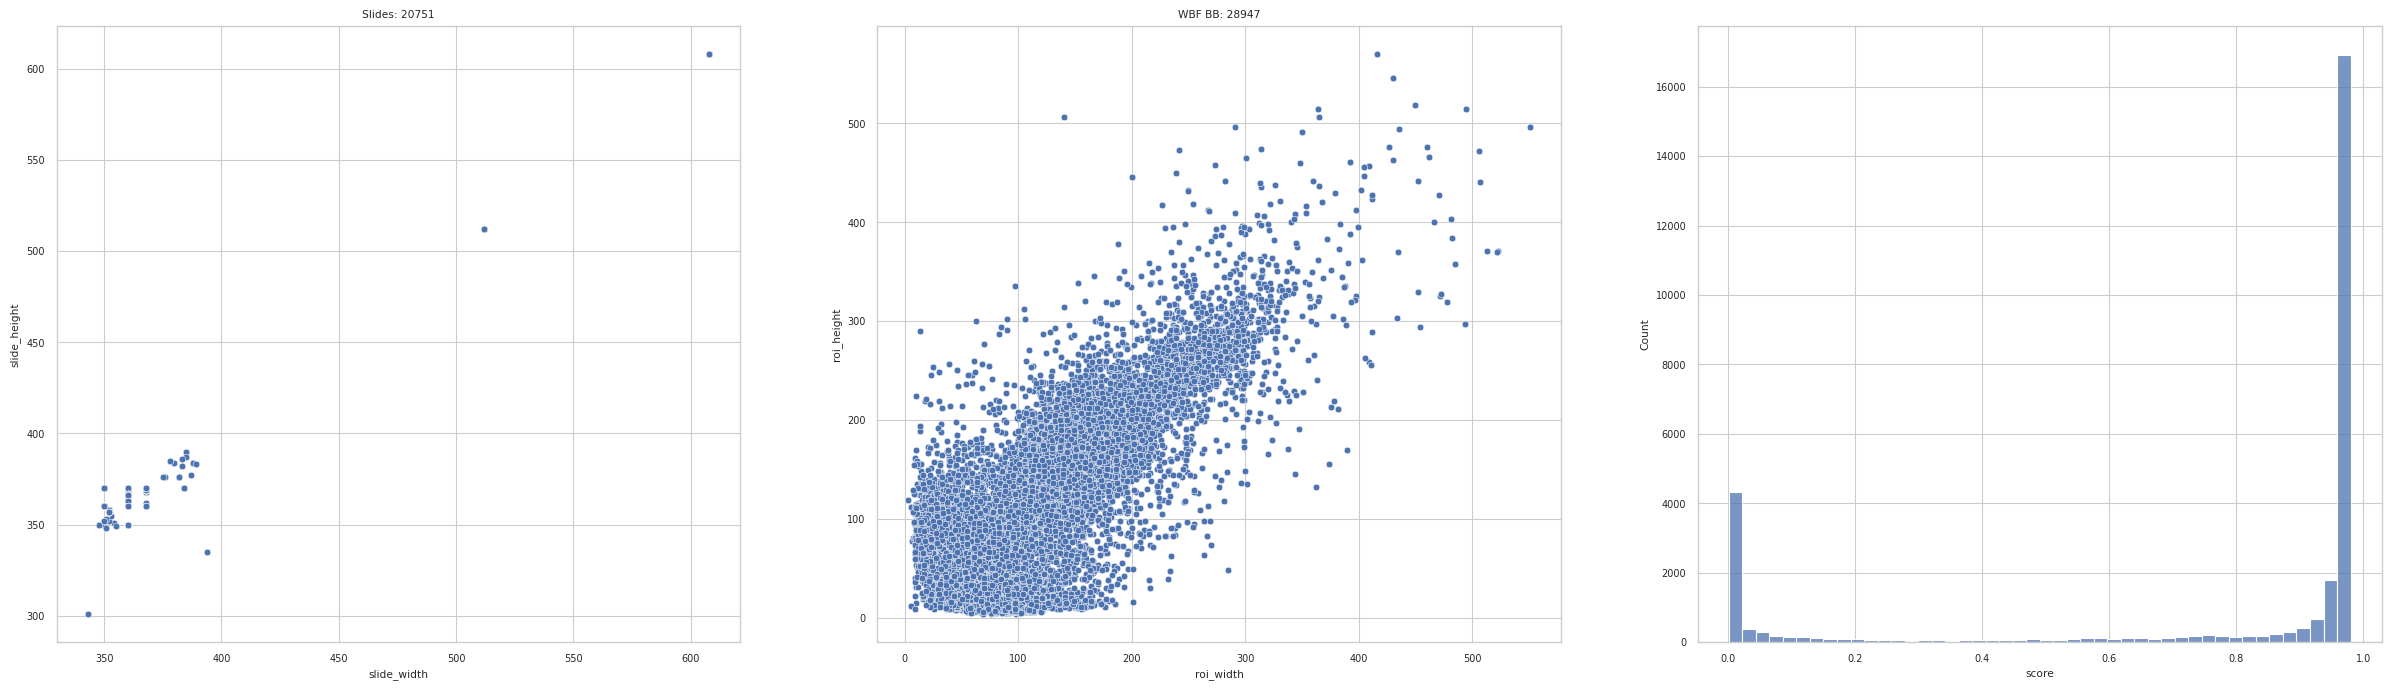

In [22]:
roi_predictions_wbf = run_wbf(test_roi_predictions_pd, iou_thr=WBF_IOU, skip_box_thr=0.0001)
roi_predictions_wbf["bbx_xtl"] = roi_predictions_wbf["bbx_xtl"].apply(lambda x: np.round(x)).astype(np.int32)
roi_predictions_wbf["bbx_xbr"] = roi_predictions_wbf["bbx_xbr"].apply(lambda x: np.round(x)).astype(np.int32)
roi_predictions_wbf["bbx_ybr"] = roi_predictions_wbf["bbx_ybr"].apply(lambda x: np.round(x)).astype(np.int32)
roi_predictions_wbf["bbx_ytl"] = roi_predictions_wbf["bbx_ytl"].apply(lambda x: np.round(x)).astype(np.int32)
roi_predictions_wbf["roi_width"] = roi_predictions_wbf["bbx_xbr"] - roi_predictions_wbf["bbx_xtl"]
roi_predictions_wbf["roi_height"] = roi_predictions_wbf["bbx_ybr"] - roi_predictions_wbf["bbx_ytl"]
roi_predictions_wbf["roi_surface"] = roi_predictions_wbf["roi_width"]*roi_predictions_wbf["roi_height"]
roi_predictions_wbf["roi_surface_ratio"] = roi_predictions_wbf["roi_surface"]*100./(roi_predictions_wbf["slide_width"]*roi_predictions_wbf["slide_height"])
roi_predictions_wbf["predict_bb"] = roi_predictions_wbf[["bbx_xtl", "bbx_xbr", "bbx_ytl", "bbx_ybr", "class", "roi_surface_ratio", "score"]].apply(lambda x: (x[0], x[1], x[2], x[3], x[4], x[5], x[6]), axis=1)
roi_predictions_wbf.to_parquet(os.path.join(DATA_ROOT, "test_wbf_%s_%d_%s.parquet" % (ROOT, IMG_SIZE, VERSION)))
print(roi_predictions_wbf.shape)
fig, ax = plt.subplots(1, 3, figsize=(30,8))
d = sns.scatterplot(data=roi_predictions_wbf, x="slide_width", y="slide_height", ax=ax[0])
d = sns.scatterplot(data=roi_predictions_wbf, x="roi_width", y="roi_height", ax=ax[1])
d = sns.histplot(data=roi_predictions_wbf, x="score", ax=ax[2])
d = ax[0].set_title("Slides: %d" % roi_predictions_wbf["filename"].nunique())
d = ax[1].set_title("WBF BB: %d" % roi_predictions_wbf.shape[0])
plt.show()

## Merge with TRUSTII_ID
Keep the N bounding boxes expected with highest confidence.

In [23]:
print(test_pd.shape)
test_image_pd = test_pd.groupby("NAME")[["trustii_id"]].agg(trustii_ids=("trustii_id", list), trustii_bbs=("trustii_id", 'count')).reset_index()
a = test_image_pd.groupby("trustii_bbs")["NAME"].count().reset_index()
a["percent"] = a["NAME"]*100/a["NAME"].sum()
a

(22689, 2)


trustii_bbs   NAME    percent
0             1  19373  93.359356
1             2   1110   5.349140
2             3    151   0.727676
3             4     48   0.231314
4             5     26   0.125295
5             6     12   0.057829
6             7     14   0.067467
7             8      8   0.038552
8             9      4   0.019276
9            10      4   0.019276
10           11      1   0.004819

In [24]:
roi_image_predictions_wbf = roi_predictions_wbf.sort_values(["filename", "score", "roi_surface_ratio"], ascending=[True, False, False]).reset_index(drop=True)
roi_image_predictions_wbf = roi_image_predictions_wbf.groupby(["filename", "slide_width", "slide_height"])[["predict_bb"]].agg(list).reset_index().rename(columns={'filename':'NAME'})
roi_image_predictions_wbf["predict_bbs"] = roi_image_predictions_wbf["predict_bb"].apply(lambda x: len(x))
roi_image_predictions_wbf = pd.merge(roi_image_predictions_wbf, test_image_pd, on="NAME", how="inner")
print("Too much predictions:", roi_image_predictions_wbf[roi_image_predictions_wbf["predict_bbs"] > roi_image_predictions_wbf["trustii_bbs"]].shape)
print("Not enough predictions:", roi_image_predictions_wbf[roi_image_predictions_wbf["predict_bbs"] < roi_image_predictions_wbf["trustii_bbs"]].shape)
print("Equal predictions:", roi_image_predictions_wbf[roi_image_predictions_wbf["predict_bbs"] == roi_image_predictions_wbf["trustii_bbs"]].shape)
not_enough_predict = roi_image_predictions_wbf[roi_image_predictions_wbf["predict_bbs"] < roi_image_predictions_wbf["trustii_bbs"]]["NAME"].unique()

# Fit to expected number of BB
roi_image_predictions_wbf["predict_bb"] = roi_image_predictions_wbf[["predict_bb", "trustii_bbs", "slide_width", "slide_height"]].apply(lambda x: fit_format(x[0], x[1], x[2], x[3], padding=True, padding_policy=PADDING_POLICY), axis=1)
roi_image_predictions_wbf["predict_bbs"] = roi_image_predictions_wbf["predict_bb"].apply(lambda x: len(x))
roi_image_predictions_wbf["predict_score_avg"] = roi_image_predictions_wbf["predict_bb"].apply(lambda x: compute_bbx_avg_score(x))
print("Too much predictions:", roi_image_predictions_wbf[roi_image_predictions_wbf["predict_bbs"] > roi_image_predictions_wbf["trustii_bbs"]].shape)
print("Not enough predictions:", roi_image_predictions_wbf[roi_image_predictions_wbf["predict_bbs"] < roi_image_predictions_wbf["trustii_bbs"]].shape)
print("Equal predictions:", roi_image_predictions_wbf[roi_image_predictions_wbf["predict_bbs"] == roi_image_predictions_wbf["trustii_bbs"]].shape)

roi_image_predictions_wbf.to_parquet(os.path.join(DATA_ROOT, "test_final_%s_%d_%s.parquet" % (ROOT, IMG_SIZE, VERSION)))

Too much predictions: (4393, 7)
Not enough predictions: (10, 7)
Equal predictions: (16348, 7)


/tmp/ipykernel_814/248130967.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  roi_image_predictions_wbf["predict_bb"] = roi_image_predictions_wbf[["predict_bb", "trustii_bbs", "slide_width", "slide_height"]].apply(lambda x: fit_format(x[0], x[1], x[2], x[3], padding=True, padding_policy=PADDING_POLICY), axis=1)


Too much predictions: (0, 8)
Not enough predictions: (0, 8)
Equal predictions: (20751, 8)


In [25]:
# To submission format
submission_pd = roi_image_predictions_wbf[["NAME", "slide_width", "slide_height", "predict_score_avg", "predict_bb", "trustii_ids"]].explode(['predict_bb', 'trustii_ids']).rename(columns={'trustii_ids':'trustii_id', 'slide_height':'img_height', 'slide_width': 'img_width'})
submission_pd["pred_x1"] = submission_pd["predict_bb"].apply(lambda x: x[0]).astype(np.int32)
submission_pd["pred_y1"] = submission_pd["predict_bb"].apply(lambda x: x[2]).astype(np.int32)
submission_pd["pred_x2"] = submission_pd["predict_bb"].apply(lambda x: x[1]).astype(np.int32)
submission_pd["pred_y2"] = submission_pd["predict_bb"].apply(lambda x: x[3]).astype(np.int32)
submission_pd["class"] = submission_pd["predict_bb"].apply(lambda x: x[4]).astype(np.int32)
submission_pd["pred_score"] = submission_pd["predict_bb"].apply(lambda x: x[-1])
submission_pd["pred_width"] = submission_pd["pred_x2"] - submission_pd["pred_x1"]
submission_pd["pred_height"] = submission_pd["pred_y2"] - submission_pd["pred_y1"]
submission_pd = submission_pd.reset_index(drop=True)
# Dump predicted BBx on test dataset
dump_boxes(submission_pd, TEST_HOME, CROP_HOME_TEST, margins=CROP_MARGINS)
submission_pd.to_parquet(CROP_FILE_TEST_CLEANED)
display(submission_pd)

100%|█████████████████████████████████████████████████████████████████████| 22689/22689 [09:11<00:00, 41.12it/s]


NAME  img_width  img_height  predict_score_avg  \
0      000455d4-8.jpg        360         363           0.968919   
1      0007ccec-2.jpg        360         367           0.971941   
2      00080027-c.jpg        368         369           0.976460   
3      00084489-e.jpg        368         370           0.869360   
4      000cfe84-e.jpg        352         357           0.965141   
...               ...        ...         ...                ...   
22684  fffff491-3.jpg        360         360           0.203012   
22685  fffff491-3.jpg        360         360           0.203012   
22686  fffff491-3.jpg        360         360           0.203012   
22687  fffff491-3.jpg        360         360           0.203012   
22688  fffff491-3.jpg        360         360           0.203012   

                                              predict_bb trustii_id  pred_x1  \
0      (93.0, 266.0, 98.0, 265.0, 0.0, 22.10820324456...      23798       93   
1      (91.0, 272.0, 82.0, 282.0, 0.0, 27.39933393884...      22386       91   
2      (111.0, 257.0, 107.0, 261.0, 0.0, 16.557676446...      59769      111   
3      (118.0, 241.0, 115.0, 262.0, 0.0, 13.279230317...      61484      118   
4      (100.0, 253.0, 92.0, 263.0, 0.0, 20.8198051948...      36896      100   
...                                                  ...        ...      ...   
22684  (132.0, 242.0, 126.0, 244.0, 0.0, 10.015432098...      45140      132   
22685  (0.0, 43.0, 0.0, 42.0, 0.0, 1.3935185185185186...      16280        0   
22686  (273.0, 356.0, 64.0, 150.0, 0.0, 5.50771604938...      44984      273   
22687  (333.0, 359.0, 4.0, 97.0, 0.0, 1.8657407407407...      41305      333   
22688  (1.0, 77.0, 116.0, 216.0, 0.0, 5.8641975308641...      42293        1   

       pred_y1  pred_x2  pred_y2  class  pred_score  pred_width  pred_height  \
0           98      266      265      0    0.968919         173          167   
1           82      272      282      0    0.971941         181          200   
2          107      257      261      0    0.976460         146          154   
3          115      241      262      0    0.869360         123          147   
4           92      253      263      0    0.965141         153          171   
...        ...      ...      ...    ...         ...         ...          ...   
22684      126      242      244      0    0.968223         110          118   
22685        0       43       42      0    0.020844          43           42   
22686       64      356      150      0    0.009834          83           86   
22687        4      359       97      0    0.008129          26           93   
22688      116       77      216      0    0.008030          76          100   

                   filename  
0      000455d4-8-23798.png  
1      0007ccec-2-22386.png  
2      00080027-c-59769.png  
3      00084489-e-61484.png  
4      000cfe84-e-36896.png  
...                     ...  
22684  fffff491-3-45140.png  
22685  fffff491-3-16280.png  
22686  fffff491-3-44984.png  
22687  fffff491-3-41305.png  
22688  fffff491-3-42293.png  

[22689 rows x 15 columns]

## Plot some predictions in test

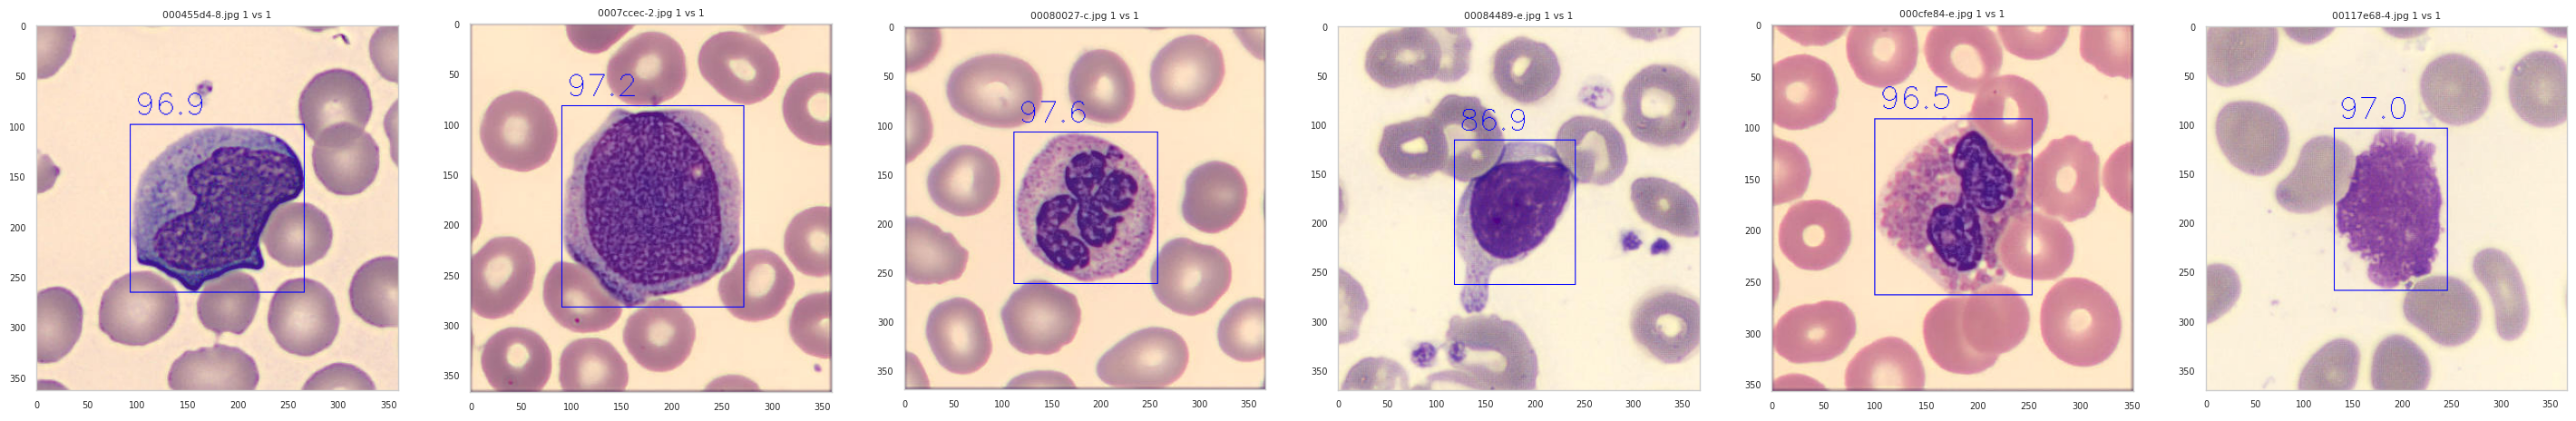

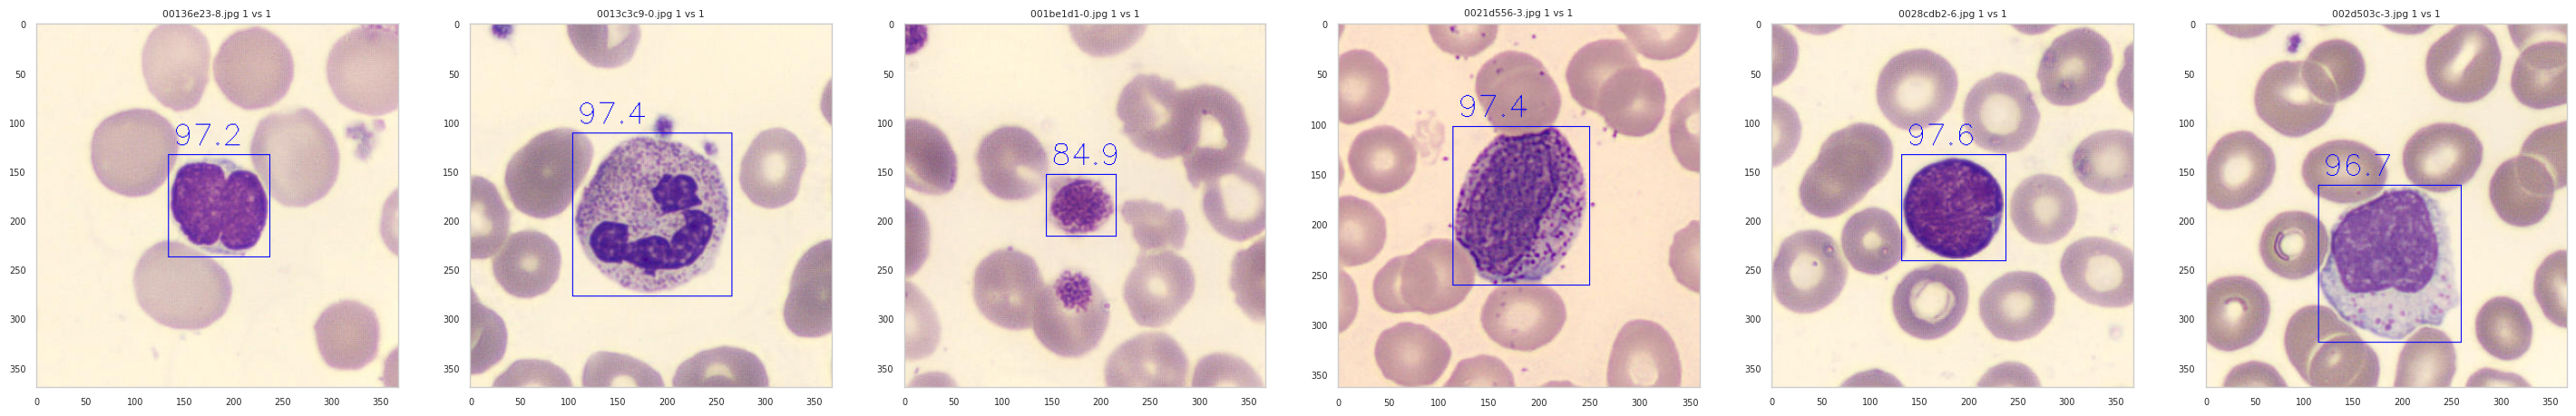

In [39]:
i, j = 0, 0
df = roi_image_predictions_wbf
for idx, row in df.iterrows():
    j = j + 1
    if j > 6*2:
        break    
    filename = row["NAME"]
    bbx = row["predict_bb"]
    trustii_bbs = row["trustii_bbs"]
    img = np.array(Image.open(os.path.join(TEST_HOME, filename)))

    for x1, x2, y1, y2, klass, surface, score in bbx:
        start_point = (int(x1), int(y1))
        end_point = (int(x2), int(y2))
        cv2.rectangle(img, start_point, end_point, color=(0,0,255), thickness=1)
        cv2.putText(
            img,
            str("%.1f"%(score*100)),
            (int(x1) + 5, int((y1) - 10)),
            fontFace = cv2.FONT_HERSHEY_SIMPLEX,
            fontScale = 1.0,
            color = (0, 0, 255),
            thickness=1)       
     
    if i == 0:
        fig, ax = plt.subplots(1, 6, figsize=(36, 14))
    d = ax[i].imshow(img)
    d = ax[i].grid(False)
    d = ax[i].set_title("%s %d vs %d" % (filename, len(bbx), trustii_bbs))
    if i == 5:
        d = plt.show()
        i = 0
    else:
        i = i + 1